In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install permetrics

## LOAD LIBRARIES

In [7]:
from transformers import BertModel, BertTokenizer, BertForPreTraining, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from textwrap import wrap
import matplotlib.pyplot as plt
import datetime
import copy

## GLOBAL VARIABLES

In [8]:
#https://www.researchgate.net/publication/345395208_BERTimbau_Pretrained_BERT_Models_for_Brazilian_Portuguese
class Config:
    NUM_GPU = 1
    NAME_MODEL = 'neuralmind/bert-base-portuguese-cased'
    MAX_LEN = 512
    RANDOM_SEED = 42
    NCLASSES = 5
    BATCH_SIZE = 16 #referencia BERTimbau 128
    LR = 0.0001 #referencia BERTimbau 1-e4
    EPOCHS = 10

config = Config()

np.random.seed(config.RANDOM_SEED)
torch.manual_seed(config.RANDOM_SEED)

## SELECT GPU

In [9]:
print("Número de GPUs disponibles:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Número de GPUs disponibles: 2
GPU 0: NVIDIA TITAN Xp
GPU 1: NVIDIA TITAN Xp


In [10]:
# Poner el GPU que deseo
torch.cuda.set_device(config.NUM_GPU)
# Para ver si esta utilizando GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#GPU usado actualmente
id_gpu = torch.cuda.current_device()
print(device,': GPU-',id_gpu)

cuda : GPU- 1


## LOAD WEIGHTS

In [11]:
# Experimento LRxLayers
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-1lastlayersdefreeze-LR1e4/checkpoint-34020'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-1lastlayersdefreeze-LR1e5/checkpoint-54723'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-1lastlayersdefreeze-LR1e6/checkpoint-45312'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-2lastlayersdefreeze-LR1e4/checkpoint-20735'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-2lastlayersdefreeze-LR1e5/checkpoint-37700'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-2lastlayersdefreeze-LR1e6/checkpoint-62304'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-4lastlayersdefreeze-LR1e4/checkpoint-18890'
PATH = './result/code_selfsupervised_BERTimabauBase-B2W-4lastlayersdefreeze-LR1e5/checkpoint-37780'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-4lastlayersdefreeze-LR1e6/checkpoint-60320'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-12lastlayersdefreeze-LR1e4/checkpoint-7552'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-12lastlayersdefreeze-LR1e5/checkpoint-15120'
#PATH = './experimento_LRxLAYERS_B2W/result/code_selfsupervised_BERTimabauBase-B2W-12lastlayersdefreeze-LR1e6/checkpoint-54752'

tokenizer = BertTokenizer.from_pretrained(config.NAME_MODEL)

modelBERT = BertModel.from_pretrained(config.NAME_MODEL,return_dict=False)# Modelo sin las capas de entrenamiento autosupervisionado

modelPreTraining = BertForPreTraining.from_pretrained(PATH)

#Pasar los pesos a un nuevo BERT
modelBERT.load_state_dict(modelPreTraining.bert.state_dict(), strict=False)#Para que no haya problemas al cargar distinto tipos de capas

modelBERT

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [12]:
# Pesos antes de entrenamiento
for name, param in modelBERT.named_parameters():
    print('------------------')
    print("=== Name: ",name)
    print('------------------')
    print(param)

------------------
=== Name:  embeddings.word_embeddings.weight
------------------
Parameter containing:
tensor([[ 0.0093, -0.0205,  0.0447,  ..., -0.0483, -0.0463,  0.0023],
        [ 0.0062, -0.0326,  0.0464,  ..., -0.0632, -0.0596, -0.0063],
        [-0.0138, -0.0493,  0.0093,  ..., -0.0138, -0.0428, -0.0009],
        ...,
        [ 0.0775, -0.0109,  0.0108,  ..., -0.0153, -0.0487,  0.0007],
        [ 0.0210, -0.0360,  0.0549,  ..., -0.0338, -0.0591,  0.0032],
        [-0.0074, -0.0173,  0.0024,  ..., -0.0348, -0.0257, -0.0028]],
       requires_grad=True)
------------------
=== Name:  embeddings.position_embeddings.weight
------------------
Parameter containing:
tensor([[-0.0378,  0.0038, -0.0299,  ...,  0.0320,  0.0005, -0.0145],
        [-0.0175, -0.0197,  0.0336,  ...,  0.0171,  0.0136, -0.0134],
        [ 0.0025, -0.0349,  0.0170,  ..., -0.0021,  0.0155, -0.0122],
        ...,
        [ 0.0081,  0.0739,  0.0219,  ..., -0.0117,  0.0033,  0.0668],
        [ 0.0169,  0.0470,  0.02

## FREEZE ALL LAYERS

In [13]:
# Congelar, por defecto todo esta congelado
for name, param in modelBERT.named_parameters():
    print(name)
    param.requires_grad = False
    print(param.requires_grad)

embeddings.word_embeddings.weight
False
embeddings.position_embeddings.weight
False
embeddings.token_type_embeddings.weight
False
embeddings.LayerNorm.weight
False
embeddings.LayerNorm.bias
False
encoder.layer.0.attention.self.query.weight
False
encoder.layer.0.attention.self.query.bias
False
encoder.layer.0.attention.self.key.weight
False
encoder.layer.0.attention.self.key.bias
False
encoder.layer.0.attention.self.value.weight
False
encoder.layer.0.attention.self.value.bias
False
encoder.layer.0.attention.output.dense.weight
False
encoder.layer.0.attention.output.dense.bias
False
encoder.layer.0.attention.output.LayerNorm.weight
False
encoder.layer.0.attention.output.LayerNorm.bias
False
encoder.layer.0.intermediate.dense.weight
False
encoder.layer.0.intermediate.dense.bias
False
encoder.layer.0.output.dense.weight
False
encoder.layer.0.output.dense.bias
False
encoder.layer.0.output.LayerNorm.weight
False
encoder.layer.0.output.LayerNorm.bias
False
encoder.layer.1.attention.self.query

## LOAD DATA B2W

In [14]:
# 10% data
df_data = pd.read_csv('../../dataset/df_classification_10porcent_b2w_2024-02-17.csv', delimiter=',')#, usecols =['review_text','overall_rating'])# index_col=0,
df_data.head()

,label,review
0,5,Muito bom. Material bonito e resistente. Cumpr...
1,5,Muito bom . Melhor celular na fixa de preço. s...
2,4,Imagem da câmera excelente durante o dia e à n...
3,2,Cumpre o que promete. Acabamento de médio para...
4,5,Diminuem o espaço usado no guarda-roupa Quali...


In [15]:
df_data['label'].value_counts()

label
5    4652
4    3181
1    2461
3    1586
2     800
Name: count, dtype: int64

In [16]:
#Cambiamos el label
df_data.loc[(df_data['label']==1), 'label'] = 0
df_data.loc[(df_data['label']==2), 'label'] = 1
df_data.loc[(df_data['label']==3), 'label'] = 2
df_data.loc[(df_data['label']==4), 'label'] = 3
df_data.loc[(df_data['label']==5), 'label'] = 4

df_data['label'].value_counts()

label
4    4652
3    3181
0    2461
2    1586
1     800
Name: count, dtype: int64

## BALANCE TRAINING CLASSES

In [17]:
num_minor_label = 800
# Obteniendo registros random del total de la misma etiqueta
label_0 = df_data.loc[df_data['label']==0,].sample(num_minor_label, random_state=config.RANDOM_SEED)
label_1 = df_data.loc[df_data['label']==1,]
label_2 = df_data.loc[df_data['label']==2,].sample(num_minor_label, random_state=config.RANDOM_SEED)
label_3 = df_data.loc[df_data['label']==3,].sample(num_minor_label, random_state=config.RANDOM_SEED)
label_4 = df_data.loc[df_data['label']==4,].sample(num_minor_label, random_state=config.RANDOM_SEED)
# Juntando todos los grupos y barajemos
df_data_new = (pd.concat([label_0, label_1, label_2, label_3, label_4])).sample(frac=1, random_state=config.RANDOM_SEED).reset_index(drop=True)
print(df_data_new.head())
print('------------------------------')
df_data_new['label'].value_counts()

   label                                             review
0      0  não recomendo esse aparelho pós estou arrepend...
1      4  Produto muito confortável . Já  é a terceira v...
2      0  Com defeito,fiz a devolução através do correio...
3      4  Ótimo produto!!! Entrega rápida!! Chegou em 3 ...
4      3  Gostei muito do produto, chegou antes do previ...
------------------------------


label
0    800
4    800
3    800
2    800
1    800
Name: count, dtype: int64

## CREATE DATALOADER

In [18]:
class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len#maximo cantidad de tokens

  def __len__(self):
      return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    #La forma en que ingresara a BERT
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        #pad_to_max_length = True,
        padding='max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      } 


#Cargando los datos
def textDataSet(df, tokenizer, max_len):
  dataset = IMDBDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return dataset

#CARGANDO LOS DATOS DE TRAIN Y VAL
dataset = textDataSet(df_data_new, tokenizer, config.MAX_LEN)

## CLASSIFICATION MODEL

In [19]:
# EL MODELO!
class BERTMultiClass(nn.Module):

  def __init__(self, n_classes):
    super(BERTMultiClass, self).__init__()
    self.bert = modelBERT
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

  def name(self):
    return "BERTMultiClass"

## CROSS VALIDATION

In [20]:
# Validación cruzada k fold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from permetrics.classification import ClassificationMetric

# Define k-fold cross-validation
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=config.RANDOM_SEED)

# Initialize lists to store metric for each fold
fold_was = []
fold_bas = []
fold_f1s = []

# TRAINING

In [21]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  val_predictions = []
  val_labels = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, predicted_labels = torch.max(outputs, dim=1)
      
      val_predictions.extend(predicted_labels.tolist())
      val_labels.extend(labels.tolist())
  return val_predictions, val_labels

Tiempo inicial: 07/22/2024, 17:54:38
Training Fold 1/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 1: 0.773
Balanced Accuracy for Fold 1: 0.4325
Weighted F1 for Fold 1: 0.42348190317813833


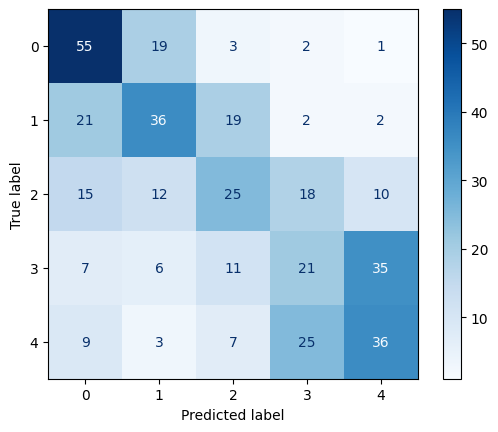

------------------
Training Fold 2/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 2: 0.7829999999999999
Balanced Accuracy for Fold 2: 0.4574999999999999
Weighted F1 for Fold 2: 0.435753726511813


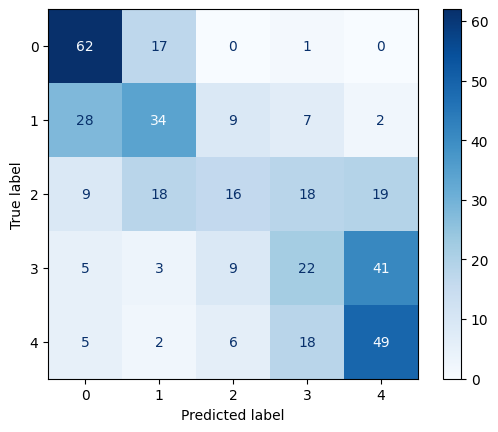

------------------
Training Fold 3/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 3: 0.7829999999999999
Balanced Accuracy for Fold 3: 0.4575
Weighted F1 for Fold 3: 0.432772810771273


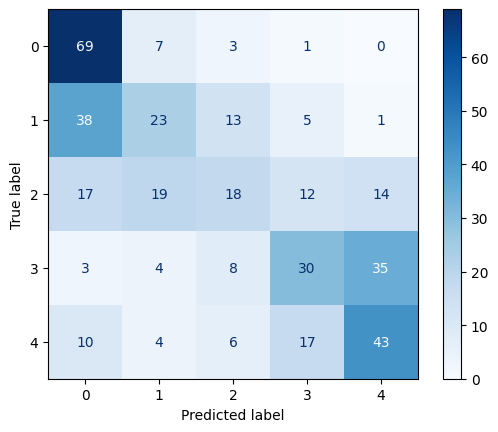

------------------
Training Fold 4/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 4: 0.791
Balanced Accuracy for Fold 4: 0.47750000000000004
Weighted F1 for Fold 4: 0.45553310143646475


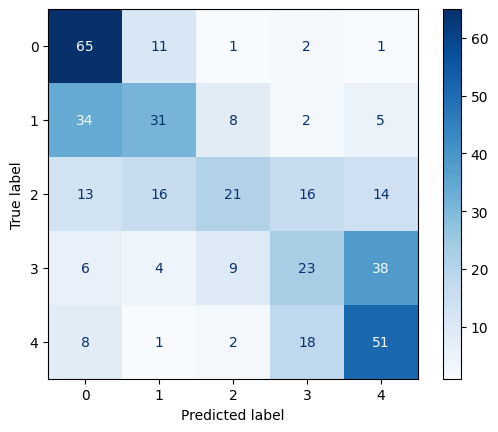

------------------
Training Fold 5/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 5: 0.775
Balanced Accuracy for Fold 5: 0.4375
Weighted F1 for Fold 5: 0.4102619793903046


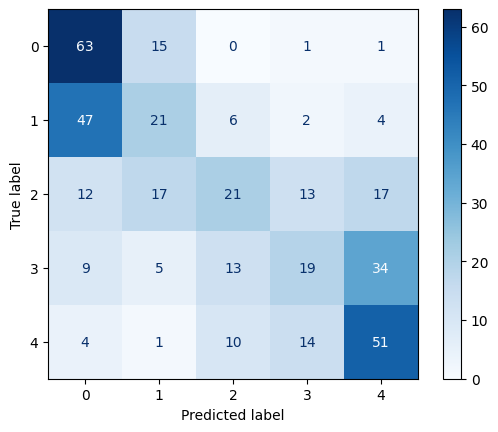

------------------
Training Fold 6/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 6: 0.78
Balanced Accuracy for Fold 6: 0.45
Weighted F1 for Fold 6: 0.4326777813030038


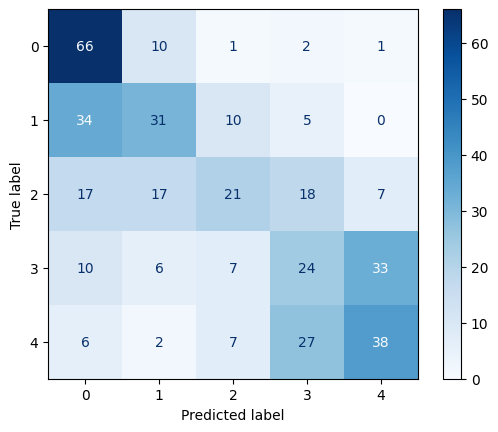

------------------
Training Fold 7/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 7: 0.7859999999999999
Balanced Accuracy for Fold 7: 0.465
Weighted F1 for Fold 7: 0.4495309088595281


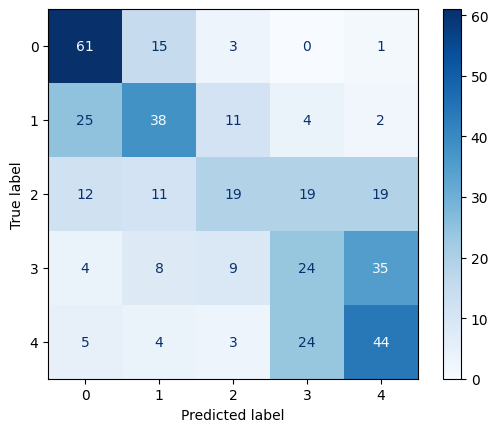

------------------
Training Fold 8/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 8: 0.772
Balanced Accuracy for Fold 8: 0.43000000000000005
Weighted F1 for Fold 8: 0.41362120582778694


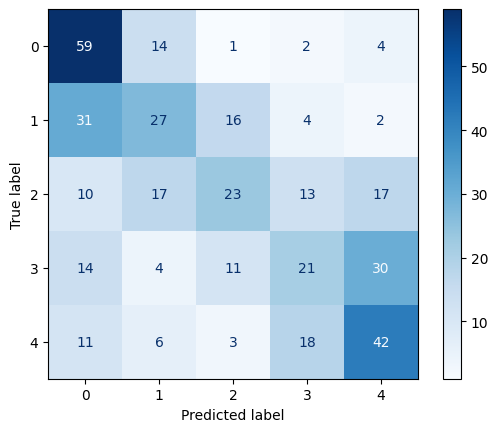

------------------
Training Fold 9/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 9: 0.777
Balanced Accuracy for Fold 9: 0.4425
Weighted F1 for Fold 9: 0.4174452142758902


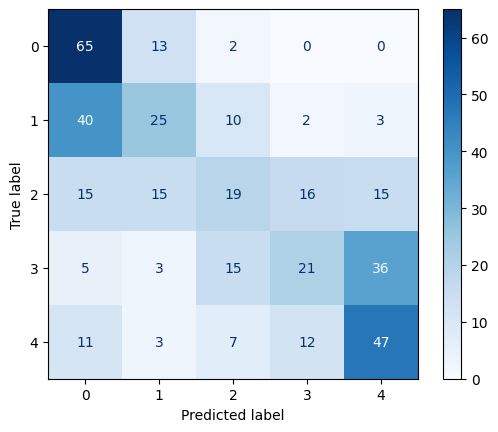

------------------
Training Fold 10/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 10: 0.7979999999999999
Balanced Accuracy for Fold 10: 0.495
Weighted F1 for Fold 10: 0.48268396722622725


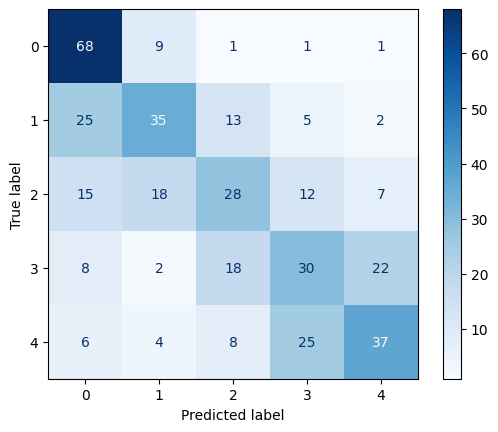

------------------
******************************************
Average Weighted Accuracy: 0.7818
Std Weighted Accuracy: 0.00783326241102643
Average Balanced Accuracy: 0.4545
Std Balanced Accuracy: 0.019583156027566138
Average Weighted F1: 0.43537625987804296
Std Weighted F1: 0.021037778679581


In [22]:
### Reference: https://vtiya.medium.com/lets-code-k-fold-validation-on-bert-722f9438f932
#Tiempo
start = datetime.datetime.now()
print('Tiempo inicial:', start.strftime("%m/%d/%Y, %H:%M:%S"))

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(skf.split(df_data_new['review'], df_data_new['label'])):
    print(f"Training Fold {fold+1}/{k_folds}")
    
    # Split dataset into train and validation sets for the current fold
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers = 4)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers = 4)
    
    # MODEL
    # Instanciando el modelo
    classificationModel = BERTMultiClass(config.NCLASSES)
    classificationModel = classificationModel.to(device)
    
    # HIPERPARAMETRO
    optimizer = AdamW(classificationModel.parameters(), lr=config.LR)#, correct_bias=False)
    total_steps = len(train_loader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device) # Funcion de perdida
        
    epoch = 0 # Inicializar
    
    # Entrenamiento!!!
    while epoch < config.EPOCHS:
      epoch += 1
      print('... Epoch {} de {}'.format(epoch, config.EPOCHS))
            
      train_model(
          classificationModel, train_loader, loss_fn, optimizer, device, scheduler, len(train_loader)
      )
    # Validacion
    val_predictions, val_labels = eval_model(
      classificationModel, val_loader, loss_fn, device, len(val_loader)
    )
    # Weighted Accuracy
    cm = ClassificationMetric(val_labels, val_predictions)
    fold_wa = cm.AS(average="weighted")
    fold_was.append(fold_wa)
    # Balanced Accuracy
    fold_ba = balanced_accuracy_score(val_labels, val_predictions)
    fold_bas.append(fold_ba)
    # Weighted F1 score
    fold_f1 = f1_score(val_labels, val_predictions, average='weighted')
    fold_f1s.append(fold_f1)
    print(f"Weighted Accuracy for Fold {fold+1}: {fold_wa}")
    print(f"Balanced Accuracy for Fold {fold+1}: {fold_ba}")
    print(f"Weighted F1 for Fold {fold+1}: {fold_f1}")
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    # Visualizar la matriz de confusión
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()
    print('------------------')
print('******************************************')
# Calculate average and std across all folds
print(f"Average Weighted Accuracy: {np.mean(fold_was)}")
print(f"Std Weighted Accuracy: {np.std(fold_was)}")
print(f"Average Balanced Accuracy: {np.mean(fold_bas)}")
print(f"Std Balanced Accuracy: {np.std(fold_bas)}")
print(f"Average Weighted F1: {np.mean(fold_f1s)}")
print(f"Std Weighted F1: {np.std(fold_f1s)}")

In [23]:
end = datetime.datetime.now()
print('Tiempo Final:', end.strftime("%m/%d/%Y, %H:%M:%S"))
print('Demoro en total:', end-start)

Tiempo Final: 07/23/2024, 00:11:22
Demoro en total: 6:16:43.778323


In [24]:
print(f"Average Weighted Accuracy: {np.mean(fold_was)}")
print(f"Std Weighted Accuracy: {np.std(fold_was)}")
print(f"Average Balanced Accuracy: {np.mean(fold_bas)}")
print(f"Std Balanced Accuracy: {np.std(fold_bas)}")
print(f"Average Weighted F1: {np.mean(fold_f1s)}")
print(f"Std Weighted F1: {np.std(fold_f1s)}")

Average Weighted Accuracy: 0.7818
Std Weighted Accuracy: 0.00783326241102643
Average Balanced Accuracy: 0.4545
Std Balanced Accuracy: 0.019583156027566138
Average Weighted F1: 0.43537625987804296
Std Weighted F1: 0.021037778679581


In [25]:
fold_bas

[0.4325,
 0.4574999999999999,
 0.4575,
 0.47750000000000004,
 0.4375,
 0.45,
 0.465,
 0.43000000000000005,
 0.4425,
 0.495]

In [26]:
fold_f1s

[0.42348190317813833,
 0.435753726511813,
 0.432772810771273,
 0.45553310143646475,
 0.4102619793903046,
 0.4326777813030038,
 0.4495309088595281,
 0.41362120582778694,
 0.4174452142758902,
 0.48268396722622725]